# Training U-Net model for coastline semantic segmentation using PyTorch

In [82]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import glob

import cv2 as cv
from PIL import Image
from osgeo import gdal

import torch 
import torch.nn as nn

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from train_unet import * #load dataset and model classes
import importlib
import utils

base_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Interpreting UNet/'


## Load test dataset and model

In [83]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# Load saved model 
model = torch.load('../../models/UNET-SCALE-13MAR23.pth', map_location=torch.device('cpu') )
model.eval()
model.to(device)

Using device: mps



build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
    )
    (pool): MaxPool2d(kernel_

# Model evaluation

Model evaluation is done using the full SWED test set. This is so we can compare the evaluation results to the SWED paper. 

In [84]:
# Load dataset
def get_loader(paths):
    TRANSFORMS = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    test_data = TrainDataset(paths, TRANSFORMS,incorrect=[])
    test_loader = DataLoader(test_data, batch_size=test_data.__len__())

    print(test_data.__len__())
    return test_loader
paths = glob.glob("../../data/SWED/test/images/*")
test_loader = get_loader(paths)

98


In [85]:
def get_preds(loader):
    images, target = next(iter(loader))
    images = images.to(device)

    # Get model output
    output = model(images)
    print(output.shape)
    # Get model predictions 
    targets = [np.array(t[1]) for t in target] 

    preds = [np.round(out) for out in output.cpu().detach()]
    preds = [np.array(pred[1]) for pred in preds]

    return images, targets, preds
images, targets, preds = get_preds(test_loader)

torch.Size([98, 2, 256, 256])


In [5]:
# Reload utils
importlib.reload(utils)

# Initialize data processor
eval = utils.model_eval(model,images,targets,preds)

Average Metrics
accuracy: 0.9375046710578763
balanced_accuracy: 0.9158109962367549
precision: 0.9238923114632744
recall: 0.9548148426223934
f1: 0.9301043811443533
Metrics
accuracy: 0.9375046710578763
balanced_accuracy: 0.9341742504111827
precision: 0.9352241050810616
recall: 0.9571356308334965
f1: 0.9460530118020545


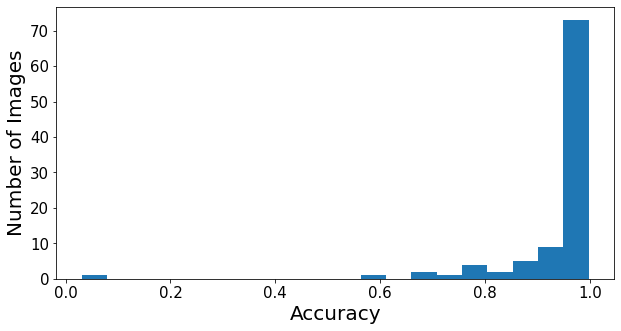

In [29]:
r_metrics, metrics = eval.eval_metrics()
accuracy = r_metrics['accuracy']

print("Average Metrics\n=================")
for m in ['accuracy','balanced_accuracy','precision','recall','f1']:
    print("{}: {}".format(m,np.mean(r_metrics[m])))

print("Metrics\n=================")
for m in ['accuracy','balanced_accuracy','precision','recall','f1']:
    print("{}: {}".format(m,metrics[m]))


# Plot accuracy
plt.figure(figsize=(10,5))

plt.hist(accuracy, bins=20)
plt.xlabel("Accuracy",size=20)
plt.ylabel("Number of Images",size=20)
plt.xticks(size=15)
plt.yticks(size=15)

# Model interpretation

Model interpretation is done after removing the images below. These are were identified to contain errors. 
<br>
../../data/SWED/test/images/S2A_MSIL2A_20190803T025551_N0213_R032_T54XWG_20190803T043943_image_0_0.tif
<br>
../../data/SWED/test/images/S2A_MSIL2A_20190901T101031_N0213_R022_T34VDM_20190901T130348_image_0_0.tif
<br>
../../data/SWED/test/images/S2A_MSIL2A_20200405T100021_N0214_R122_T34VDM_20200405T115512_image_0_0.tif
<br>
<br>


In [86]:
paths = glob.glob("../../data/SWED/test/images/*")
remove =["../../data/SWED/test/images/S2A_MSIL2A_20190803T025551_N0213_R032_T54XWG_20190803T043943_image_0_0.tif",
         "../../data/SWED/test/images/S2A_MSIL2A_20190901T101031_N0213_R022_T34VDM_20190901T130348_image_0_0.tif",
         "../../data/SWED/test/images/S2A_MSIL2A_20200405T100021_N0214_R122_T34VDM_20200405T115512_image_0_0.tif"]
paths = [p for p in paths if p not in remove]
test_loader = get_loader(paths)

images, targets, preds = get_preds(test_loader)

95
torch.Size([95, 2, 256, 256])


In [103]:
importlib.reload(utils)
eval = utils.model_eval(model,images,targets,preds)

### Average weights

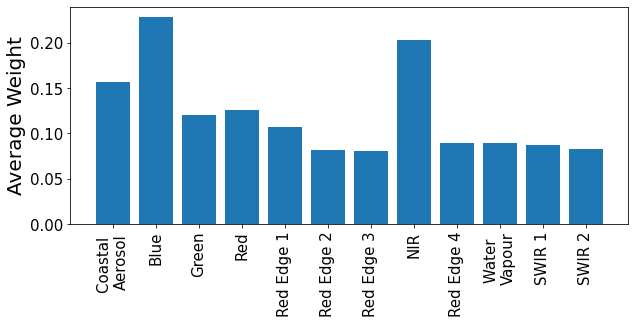

In [20]:
channels_ = ['Coastal \nAerosol','Blue','Green',
            'Red','Red Edge 1','Red Edge 2',
        'Red Edge 3','NIR','Red Edge 4',
            'Water \nVapour','SWIR 1','SWIR 2']

avg_weight = eval.get_weights()
eval.plot_importance(avg_weight,channels_,label="Average Weight",save="avg_weight")

# Permutation band importance

In [69]:
# Examples 
print(eval.get_perm_accuracy(['NIR']))
print(eval.get_perm_accuracy(['Green']))
print(eval.get_perm_accuracy(['NIR','Green']))

0.5653458444695724
0.9476197895250822
0.5938990542763158


In [96]:
band_dict = {'Coastal Aerosol':0,'Blue':1,'Green':2,
                    'Red':3,'Red Edge 1':4,'Red Edge 2':5,
                    'Red Edge 3':6,'NIR':7,'Red Edge 4':8,
                    'Water Vapour':9,'SWIR 1':10,'SWIR 2':11}

In [97]:
# Add bands for permutation importance
oringal_bands = ['Coastal Aerosol','Blue','Green',
            'Red','Red Edge 1','Red Edge 2',
        'Red Edge 3','NIR','Red Edge 4',
            'Water Vapour','SWIR 1','SWIR 2']

perm_bands = []
for band in oringal_bands:
    perm_bands.append([band])

#NDWI
perm_bands.append(['NIR','Green'])

#AWEIsh
perm_bands.append(['Blue', 'Green', 'NIR', 'SWIR 1','SWIR 2'])

#WI2 
perm_bands.append(['Blue', 'SWIR 1'])

#SWI
perm_bands.append(["Red Edge 1", "SWIR 2"])

#WI2015
perm_bands.append(['Green', 'Red', 'NIR', 'SWIR 1','SWIR 2'])

#Visiable light bands 
perm_bands.append(['Blue','Green','Red'])

#Not important bands
perm_bands.append(['Coastal Aerosol', 'Green', 'Red', 'Red Edge 1','Red Edge 2','Red Edge 3','Red Edge 4','SWIR 2'])

#Sense check 
for r_band in perm_bands:
    for band in r_band: 
        try: 
            band_dict[band]
        except:
            print("ERROR: {} not in dictionary".append(band))

In [ ]:
# Calculate permutation importance
n = 5
rows = []

accuracy = eval.get_perm_accuracy([])
rows.append([str([]),0,accuracy])

for bands in perm_bands:
    print(bands,end=" ")
    for i in range(n):
        accuracy = eval.get_perm_accuracy(bands)
        row = [str(bands),i,accuracy] 
        rows.append(row)

        print(i,end=" ")

    print()
    
df_metrics = pd.DataFrame(rows,columns = ['Bands',"Perm","Accuracy"])
df_metrics.to_csv(base_path+ 'Metrics_28MAR23.csv',index=False)
df_metrics.head()

Coastal 
Aerosol -0.21
Blue 0.19
Green -0.1
Red -0.1
Red Edge 1 -0.17
Red Edge 2 -0.27
Red Edge 3 -0.39
NIR 38.12
Red Edge 4 -0.44
Water 
Vapour 2.58
SWIR 1 0.78
SWIR 2 -0.38


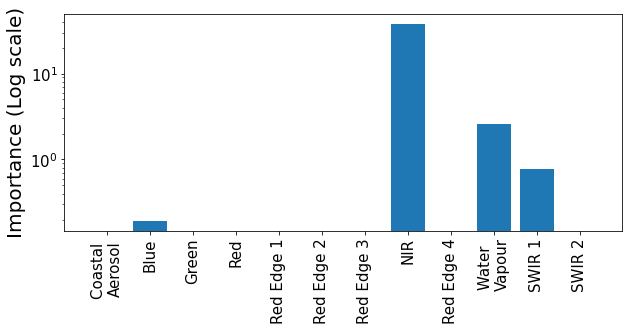

In [104]:
# Plot permutation importance for individual bands
df_metrics = pd.read_csv(base_path+ 'Metrics_28MAR23.csv')
mean = df_metrics[['Bands','Accuracy']].groupby(["Bands"], sort=False ).mean().reset_index()

orginal_accuracy = mean['Accuracy'].values[0]
bands = mean['Accuracy'].values[1:13]
importance = [(orginal_accuracy-b)*100 for b in bands]

for i,imp in enumerate(importance):
    print(channels_[i],np.round(imp,2))

eval.plot_importance(importance,channels_,label="Importance (Log scale)",save="Perm_importance")

NIR 38.12
NDWI 35.28
AWEIsh 39.2
WI2 0.46
SWI -0.34
WI2015 42.98
Visible
 Light 0.25
Not
 Important -0.47


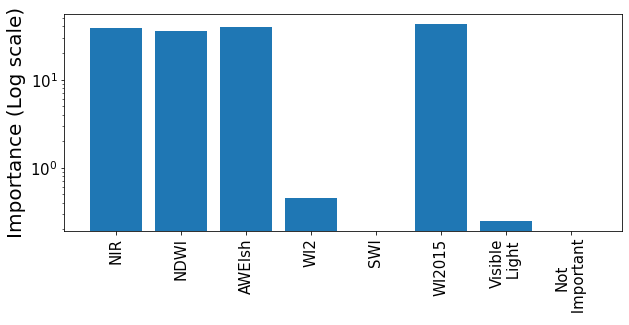

In [105]:
# Plot permutation importance for combination of bands
orginal_accuracy = mean['Accuracy'].values[0]
bands = mean['Accuracy'].values[np.r_[8,13:20]] 
importance = [(orginal_accuracy-b)*100 for b in bands]

indices = ['NIR','NDWI','AWEIsh','WI2','SWI','WI2015','Visible\n Light', 'Not\n Important']

for i,imp in enumerate(importance):
    print(indices[i],np.round(imp,2))

eval.plot_importance(importance,indices,label="Importance (Log scale)",save="Perm_importance_indices")